Accuracy: 0.926

Classification Report:
               precision    recall  f1-score   support

     No Rain       0.95      0.96      0.96       437
        Rain       0.72      0.68      0.70        63

    accuracy                           0.93       500
   macro avg       0.84      0.82      0.83       500
weighted avg       0.92      0.93      0.93       500



e:\oosun\Documents\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


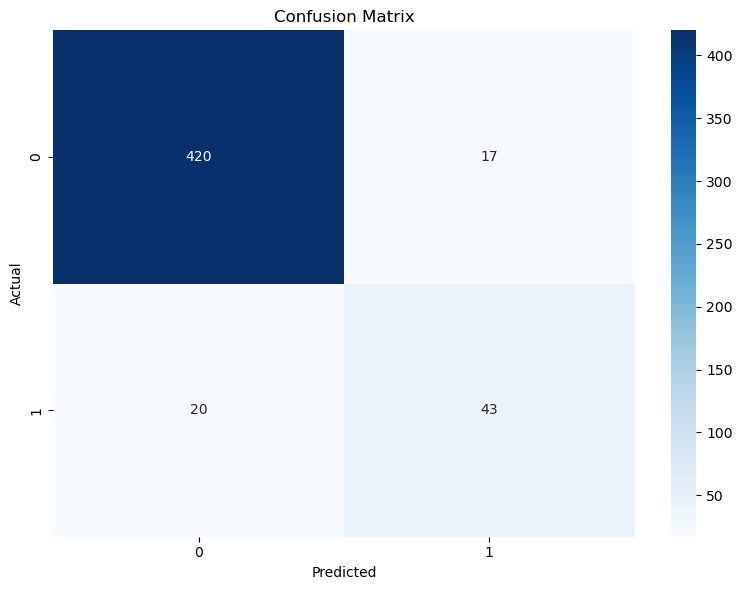

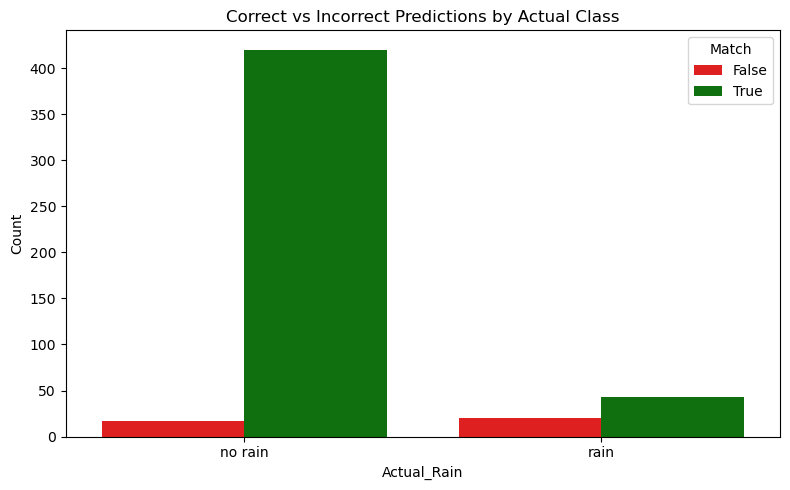

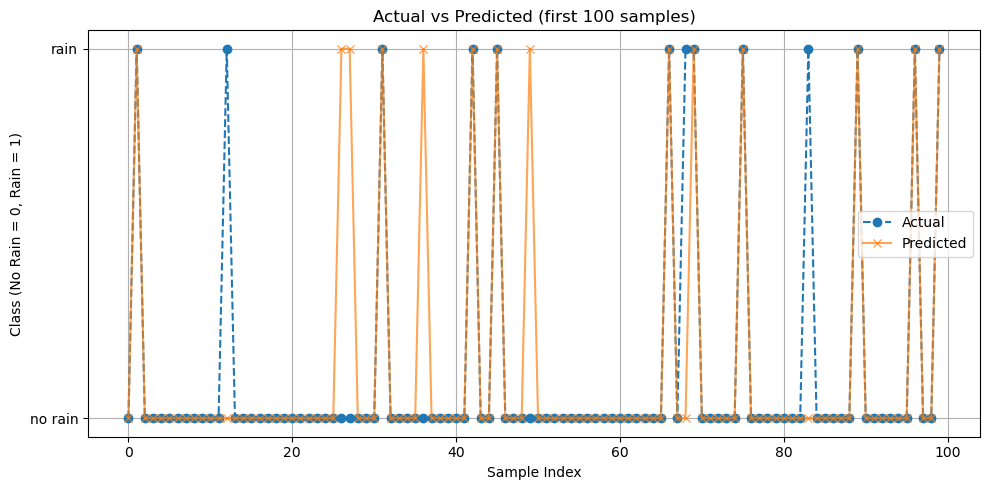

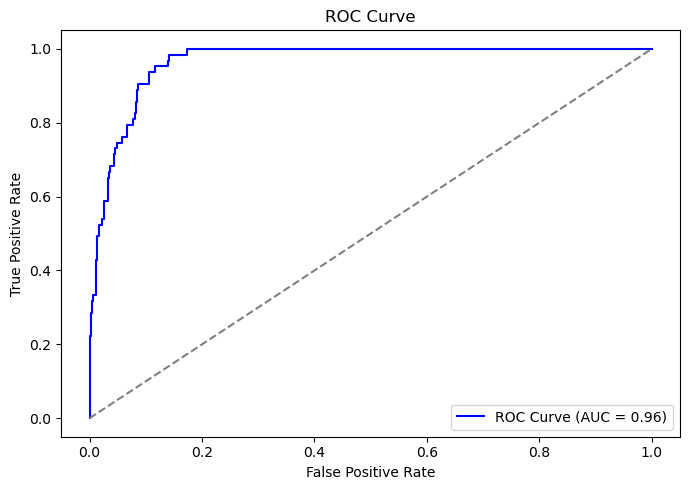

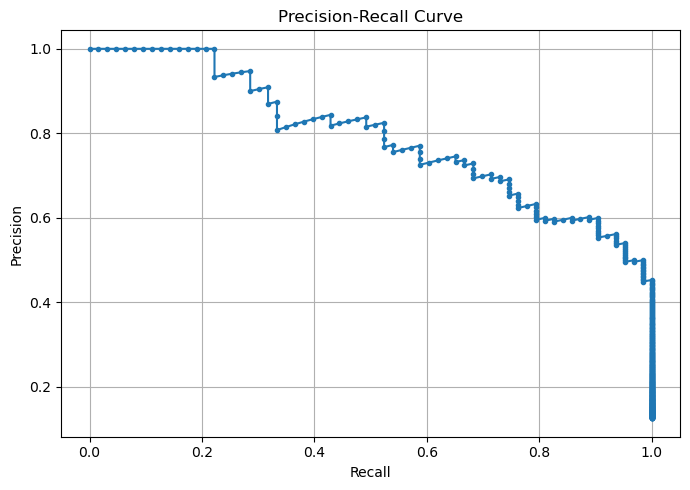

Predicted Weather Outcome: no rain ,for given weather input


C:\Users\oosun\AppData\Local\Temp\ipykernel_7472\3334876487.py:86: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_input = df_input.apply(pd.to_numeric, errors='ignore')


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve

#Step 1: Import CSVs
df_train = pd.read_csv('../Data/train_data.csv', delimiter=",") 
df_test = pd.read_csv('../Data/test_data.csv', delimiter=",")

#Step 2: Separate features and target
X_train = df_train.drop(columns = ["City", "DateTime", "Rain"])
y_train = df_train['Rain']

X_test = df_test.drop(columns = ["City", "DateTime","Rain"])
y_test = df_test['Rain']

#Step 3: Feature sclaing
scaler = StandardScaler()  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Step 4: Tune and train Logistic Regression model using GridSearchCV
#Define the model
ln = LogisticRegression(solver='lbfgs', max_iter=500)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   
    'penalty': ['l2'],              
    'max_iter': [100, 200, 500]     
}
base_model = LogisticRegression(solver='lbfgs', multi_class='auto')
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Use best model found
ln = grid_search.best_estimator_

#Step 5: Save the model as pkl file in artifacts   
with open("../Artifacts/regression_model.pkl", "wb") as file:
    pickle.dump(ln, file)
with open("../Artifacts/regression_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

#Setp 6: predictions
predictions = ln.predict(X_test_scaled)

#Step 7: Evaluation
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions, target_names=["No Rain", "Rain"], zero_division=0))

#Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Step 8: Save predictions to CSV
comparison_df = X_test.copy()
comparison_df["Actual Rain"] = y_test.values
comparison_df["Predicted Rain"] = predictions
comparison_df.to_csv("../Data/regression_prediction.csv", index=False)  

#Prediction function
def predict_weather(input_string):
    columns = ["Temperature", "Humidity", "Wind_Speed", "Cloud_Cover", "Pressure"]

    # Convert input string into a list
    input_data = input_string.split(",")

    # Automatically remove the first value (City) and second value (DateTime)
    input_data = input_data[2:]  

    # Create DataFrame from input
    df_input = pd.DataFrame([input_data], columns=columns)

    # Convert numerical values from strings to floats
    df_input = df_input.apply(pd.to_numeric, errors='ignore')  

    # Scale the input using the saved scaler
    with open("../Artifacts/regression_scaler.pkl", "rb") as f:
        scaler = pickle.load(f)

    df_input_scaled = scaler.transform(df_input)

    # Predict using the trained logistic regression model
    with open("../Artifacts/regression_model.pkl", "rb") as f:
        model = pickle.load(f)

    prediction = model.predict(df_input_scaled)

    return prediction[0]

#Match Info for Bar Plot
comparison_df["Actual_Rain"] = y_test
comparison_df["Predicted_Rain"] = predictions
comparison_df["Match"] = comparison_df["Actual_Rain"] == comparison_df["Predicted_Rain"]

#Match Count Plot
plt.figure(figsize=(8, 5))
sns.countplot(data=comparison_df, x="Actual_Rain", hue="Match", palette={True: "green", False: "red"})
plt.title("Correct vs Incorrect Predictions by Actual Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#Actual vs Predicted Scatter (first 100 samples)
plt.figure(figsize=(10, 5))
plt.plot(comparison_df["Actual_Rain"].values[:100], label="Actual", marker='o', linestyle='--')
plt.plot(comparison_df["Predicted_Rain"].values[:100], label="Predicted", marker='x', alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted (first 100 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Class (No Rain = 0, Rain = 1)")
plt.grid(True)
plt.tight_layout()
plt.show()

#ROC Curve
if hasattr(ln, "predict_proba"):
    probs = ln.predict_proba(X_test_scaled)
    probs_positive_class = probs[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs_positive_class, pos_label='rain' if y_test.dtype == object else 1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    #Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, probs_positive_class, pos_label='rain' if y_test.dtype == object else 1)
    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Example testing input from the csv file
weather_input = "Chicago,2023-12-15 01:26,27.31386567157817,94.69920342298845,13.537423774917874,56.54416888696837,1042.2283814225484"

#Print predicted grade
print(f"Predicted Weather Outcome: {predict_weather(weather_input)} ,for given weather input")
